In [35]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score


In [25]:
data = pd.read_csv('./processed_data1.csv')



In [26]:
normalized_data = (data - data.mean())/data.std()
correlation_matrix = normalized_data.corr()

print(correlation_matrix)

Unnamed: 0  event_time  event_type  product_id  category_id  \
Unnamed: 0      1.000000    0.001807    0.001801    0.000886    -0.001123   
event_time      0.001807    1.000000   -0.007045    0.003250    -0.000374   
event_type      0.001801   -0.007045    1.000000    0.012495    -0.013005   
product_id      0.000886    0.003250    0.012495    1.000000     0.062512   
category_id    -0.001123   -0.000374   -0.013005    0.062512     1.000000   
brand          -0.000786   -0.002440   -0.043414    0.070852     0.062518   
price           0.000223   -0.009797   -0.146944   -0.025952     0.014503   
user_id        -0.003176   -0.014396   -0.064841   -0.018710     0.000538   
user_session    0.000528    0.028250    0.004051    0.007619     0.015482   

                 brand     price   user_id  user_session  
Unnamed: 0   -0.000786  0.000223 -0.003176      0.000528  
event_time   -0.002440 -0.009797 -0.014396      0.028250  
event_type   -0.043414 -0.146944 -0.064841      0.004051  
product

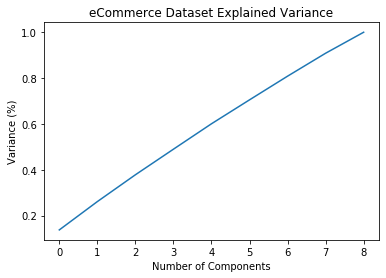

In [32]:
pca = PCA(random_state=1)
pca.fit(normalized_data.values)

#Plotting the Cumulative Summation of the Explained Variance
plt.figure()
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)') #for each component
plt.title('eCommerce Dataset Explained Variance')
plt.show()

In [29]:
print(pca.components_)

[[-1.97325816e-17 -0.00000000e+00 -9.08177850e-20  4.96929205e-13
   1.00000000e+00  1.17238004e-17  1.65937103e-18  2.78764882e-13
   2.56775935e-14]
 [ 1.07774062e-07  9.12159027e-10  8.74393558e-10  2.87824645e-04
   2.78626281e-13 -3.59639172e-09 -7.73766899e-09 -9.99999944e-01
  -1.73006411e-04]
 [-1.99216045e-06 -1.07945565e-08 -1.06711905e-08 -9.99998549e-01
   4.97051752e-13 -1.59038863e-06  3.78837987e-07 -2.87533761e-04
  -1.67902885e-03]
 [ 7.53887425e-06  5.79909421e-07  3.23429772e-08 -1.67897902e-03
  -2.47948604e-14  2.64617412e-07 -1.20465529e-06 -1.73489425e-04
   9.99998575e-01]
 [-1.00000000e+00  2.66346808e-07 -6.21453215e-07  1.97951735e-06
  -2.08797857e-17  7.96709714e-06 -2.51287788e-06 -1.08509170e-07
   7.54218447e-06]
 [ 7.65665949e-06 -5.49490447e-04 -1.93697033e-03 -1.54099041e-06
  -1.10588622e-17  9.94356986e-01  1.06066635e-01 -4.81790243e-09
  -1.37615183e-07]
 [-3.33914755e-06 -2.58412299e-03 -8.50097007e-03  5.43459843e-07
  -8.67361738e-19 -1.0608044

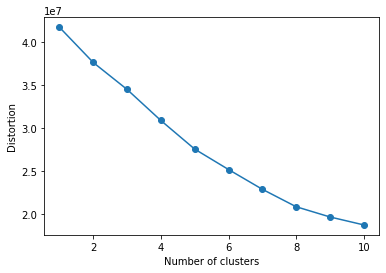

In [34]:
# calculate distortion for a range of number of cluster
distortions = []
for i in range(1, 11):
    km = KMeans(
        n_clusters=i, init='random',
        n_init=10, max_iter=300,
        tol=1e-04, random_state=1
    )
    km.fit(normalized_data)
    distortions.append(km.inertia_)

# plot
plt.plot(range(1, 11), distortions, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')
plt.show()

In [36]:
# KMeans

km = KMeans(
    n_clusters=2, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
).fit(data.values)


In [ ]:
# KMeans - normalized data

km_norm = KMeans(
    n_clusters=3, init='random',
    n_init=10, max_iter=300,
    tol=1e-04, random_state=0
).fit(normalized_data.values)


In [37]:
# DBSCAN

db = DBSCAN(eps=0.5, min_samples=3).fit(data.values)
print(db.labels_)


[-1 -1 -1 ... -1 -1 -1]


In [38]:
# DBSCAN - normalized data

db_norm = DBSCAN(eps=0.5, min_samples=3).fit(normalized_data.values)
print(db_norm.labels_)

In [ ]:
# SCORE

km_score = davies_bouldin_score(data.values, km.labels_)
dbscan_score = davies_bouldin_score(data.values, db.labels_)

In [ ]:
# SCORE - normalized data

km_score_norm = davies_bouldin_score(normalized_data.values, km.labels_)
dbscan_score_norm = davies_bouldin_score(normalized_data.values, db.labels_)

In [ ]:
print("Scores - KM vs DBSCAN: ", km_score, dbscan_score)
print("Scores - KM normalized vs DBSCAN normalized: ", km_score_norm, dbscan_score_norm)

In [7]:
X = data.values

y_km = kmForDisplay.fit_predict(X)


# plot the 2 clusters
plt.scatter(
    X[y_km == 0, 0], X[y_km == 0, 1],
    s=50, c='lightgreen',
    marker='s', edgecolor='black',
    label='cluster 1'
)

plt.scatter(
    X[y_km == 1, 0], X[y_km == 1, 1],
    s=50, c='orange',
    marker='o', edgecolor='black',
    label='cluster 2'
)

# plot the centroids
plt.scatter(
    km.cluster_centers_[:, 0], km.cluster_centers_[:, 1],
    s=250, marker='*',
    c='red', edgecolor='black',
    label='centroids'
)
plt.legend(scatterpoints=1)
plt.grid()
plt.show()